# Make-Moons Experiments (no `sklearn.datasets.make_moons`)

This notebook reproduces the full experimental pipeline requested:
- Generate Make-Moons dataset **without** `sklearn.datasets.make_moons` (custom implementation).
- Use train & test sets with 500 points each and default noise `0.2`. Also create two extra test sets with noise `0.1` and `0.3`.
- Standardize **after** the split using **train** statistics only.
- Validation split: 20% of the training set for model selection.
- Random seed: `1337`.

Models trained (all MLPs use **two hidden layers** with **4** and **6** neurons respectively):
1. MLP with early stopping (patience=50)
2. MLP with **L1** regularization (grid of λ). Report layer-wise sparsity and validation AUROC vs λ
3. MLP with **L2** regularization (tune penalty via validation)
4. Logistic Regression with polynomial features (degree 2 and 3)

Additional experiments:
- Decision boundary plots for each model (noise=0.2)
- Table of test accuracies across noise levels (0.1, 0.2, 0.3), with parameter counts
- ROC-AUC plots
- Add class imbalance (70:30) in the train set (keep test balanced) and report accuracy & AUROC; discuss

**Notes**:
- Seed set to `1337` for reproducibility.
- The notebook is runnable and contains visualization code. Run the cells in order.
- To reproduce training results exactly, run on a machine with same package versions; PyTorch/CUDA availability may affect speed.


In [1]:
# Suppress library warnings
import warnings
warnings.filterwarnings("ignore")

# Cell: Imports, random seeds, and helper functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import math
from typing import Tuple, Dict, List

# Reproducibility
SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


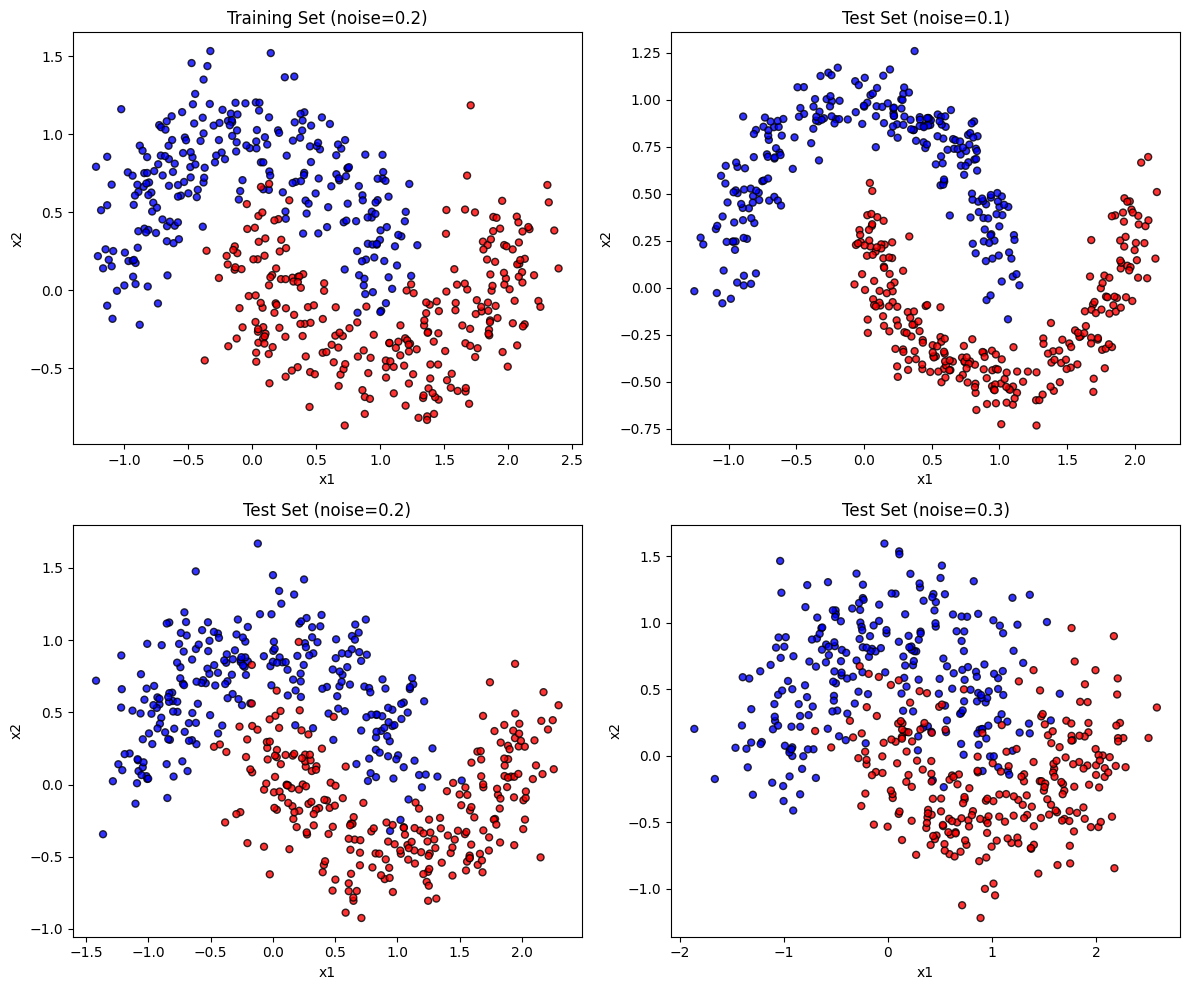

In [2]:
# Cell: Custom make_moons implementation and dataset creation (no sklearn.make_moons)
def make_moons_custom(n_samples=500, noise=0.2, random_state=None):

    if random_state is not None:
        rng = np.random.RandomState(random_state)  # REproduce Randomness a
    else:
        rng = np.random

    n_out = n_samples // 2 # split the two points in two classes
    n_in = n_samples - n_out

    # Outer (first) moon
    theta_out = rng.uniform(0, math.pi, n_out)
    x_out = np.column_stack([np.cos(theta_out), np.sin(theta_out)])

    # Inner (second) moon - flipped and shifted
    theta_in = rng.uniform(0, math.pi, n_in)
    x_in = np.column_stack([1 - np.cos(theta_in),  -np.sin(theta_in) + 0.5])

    X = np.vstack([x_out, x_in])
    y = np.hstack([np.zeros(n_out, dtype=int), np.ones(n_in, dtype=int)])

    # Add isotropic Gaussian noise
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

# Create datasets
N_TRAIN = 500
N_TEST = 500

X_train_raw, y_train_raw = make_moons_custom(N_TRAIN, noise=0.2, random_state=SEED)
X_test_20, y_test_20 = make_moons_custom(N_TEST, noise=0.2, random_state=SEED+1)
X_test_10, y_test_10 = make_moons_custom(N_TEST, noise=0.1, random_state=SEED+2)
X_test_30, y_test_30 = make_moons_custom(N_TEST, noise=0.3, random_state=SEED+3)

# Plot all datasets with different noise levels
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Training set (noise=0.2)
axes[0].scatter(X_train_raw[:,0], X_train_raw[:,1], c=y_train_raw, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[0].set_title('Training Set (noise=0.2)')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# Test sets with different noise levels
axes[1].scatter(X_test_10[:,0], X_test_10[:,1], c=y_test_10, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[1].set_title('Test Set (noise=0.1)')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

axes[2].scatter(X_test_20[:,0], X_test_20[:,1], c=y_test_20, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[2].set_title('Test Set (noise=0.2)')
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')

axes[3].scatter(X_test_30[:,0], X_test_30[:,1], c=y_test_30, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[3].set_title('Test Set (noise=0.3)')
axes[3].set_xlabel('x1')
axes[3].set_ylabel('x2')

plt.tight_layout()
plt.show()

In [3]:

# Cell: Preprocessing - standardize using train statistics only, and create validation split
scaler = StandardScaler()  # x' = x - mean(train)/variance(train)
# Fit on training data only
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)  # we find the variance and mean usint the Standatscaler feature and then use the same variance and mean to predict dataset
X_test_20_s = scaler.transform(X_test_20)
X_test_10_s = scaler.transform(X_test_10)
X_test_30_s = scaler.transform(X_test_30)

# Validation split from training set (20%)
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train_raw, test_size=0.2, stratify=y_train_raw, random_state=SEED
)

print('Shapes:', X_train_main.shape, X_val.shape, X_test_20_s.shape)


Shapes: (400, 2) (100, 2) (500, 2)


In [4]:
# Cell: Define MLP (two hidden layers: 4 and 6 neurons), training loop with early stopping,
# and utilities for L1/L2 penalties and evaluation metrics.

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden1=4, hidden2=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)  # h1 = ReLU(x*W1 +b1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 1)  # binary classification
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze(-1)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_layerwise_sparsity(model: nn.Module, tol=1e-6):
    sparsity = {}
    for name, p in model.named_parameters():
        if 'weight' in name:
            total = p.numel()
            zero = (p.abs() <= tol).sum().item()
            sparsity[name] = zero / total
    return sparsity

def train_model(model, X_train, y_train, X_val, y_val,
                epochs=1000, batch_size=64, lr=1e-3, weight_decay=0.0,
                l1_lambda=0.0, patience=50, verbose=False, class_weights=None): # Added class_weights parameter
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Use BCEWithLogitsLoss with pos_weight for class weights
    if class_weights is not None:
        # Assuming class_weights is a tensor where class_weights[1] is weight for positive class
        # BCEWithLogitsLoss expects pos_weight to be a tensor of weights for the positive class
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1]], device=device))
    else:
        criterion = nn.BCEWithLogitsLoss()

    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    best = {'epoch':-1, 'val_loss':np.inf, 'state_dict':None}
    wait = 0
    history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)  # Outputs raw logits
            loss = criterion(logits, yb)
            # L1 penalty
            if l1_lambda > 0:
                l1_pen = 0.0
                for name, p in model.named_parameters():
                    if 'weight' in name:
                        l1_pen = l1_pen + p.abs().sum()
                loss = loss + l1_lambda * l1_pen
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # Validation
        model.eval()
        with torch.no_grad():
            xb = torch.tensor(X_val, dtype=torch.float32).to(device)
            yb = torch.tensor(y_val, dtype=torch.float32).to(device)
            logits = model(xb)  # Outputs raw logits
            val_loss = criterion(logits, yb).item()
            val_probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities for AUC
            val_auc = roc_auc_score(y_val, val_probs)
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        if val_loss < best['val_loss'] - 1e-8:
            best.update({'epoch': epoch, 'val_loss': val_loss, 'state_dict': model.state_dict()})
            wait = 0
        else:
            wait += 1
        if verbose and (epoch % 50 == 0):
            print(f'Epoch {epoch:04d} train_loss={history["train_loss"][-1]:.4f} val_loss={val_loss:.4f} val_auc={val_auc:.4f}')
        if wait >= patience:
            if verbose:
                print(f'Early stopping at epoch {epoch}, best epoch {best["epoch"]} val_loss {best["val_loss"]:.4f}')
            break
    # load best
    if best['state_dict'] is not None:
        model.load_state_dict(best['state_dict'])
    return model, history

In [5]:

# Cell: Train baseline MLP with early stopping (no L1/L2)
model_base = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
print('Param count (baseline MLP):', count_parameters(model_base))
model_base_trained, history_base = train_model(
    model_base, X_train_main, y_train_main, X_val, y_val,
    epochs=2000, batch_size=64, lr=1e-3, patience=50, verbose=True
)

# Validation AUC
from sklearn.metrics import roc_auc_score
model_base_trained.eval()
with torch.no_grad():
    val_logits = model_base_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
val_auc_base = roc_auc_score(y_val, val_probs)
print('Base MLP validation AUC:', val_auc_base)


Param count (baseline MLP): 49
Epoch 0000 train_loss=0.7337 val_loss=0.7300 val_auc=0.0692
Epoch 0050 train_loss=0.4910 val_loss=0.4827 val_auc=0.9560
Epoch 0100 train_loss=0.2425 val_loss=0.2928 val_auc=0.9476
Epoch 0150 train_loss=0.2023 val_loss=0.2660 val_auc=0.9596
Epoch 0200 train_loss=0.2087 val_loss=0.2477 val_auc=0.9652
Epoch 0250 train_loss=0.1837 val_loss=0.2196 val_auc=0.9704
Epoch 0300 train_loss=0.1286 val_loss=0.1809 val_auc=0.9780
Epoch 0350 train_loss=0.1011 val_loss=0.1230 val_auc=0.9952
Epoch 0400 train_loss=0.0769 val_loss=0.0884 val_auc=0.9976
Epoch 0450 train_loss=0.0670 val_loss=0.0740 val_auc=0.9976
Epoch 0500 train_loss=0.0501 val_loss=0.0654 val_auc=0.9980
Epoch 0550 train_loss=0.0432 val_loss=0.0610 val_auc=0.9984
Epoch 0600 train_loss=0.0403 val_loss=0.0584 val_auc=0.9988
Epoch 0650 train_loss=0.0397 val_loss=0.0572 val_auc=0.9984
Epoch 0700 train_loss=0.0330 val_loss=0.0552 val_auc=0.9984
Epoch 0750 train_loss=0.0321 val_loss=0.0542 val_auc=0.9984
Epoch 080

In [6]:

# Cell: L1 regularization grid search
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for lam in l1_grid:
    print('Training with L1 lambda =', lam)
    model = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
    m_trained, hist = train_model(model, X_train_main, y_train_main, X_val, y_val,
                                  epochs=2000, batch_size=64, lr=1e-3, l1_lambda=lam, patience=50, verbose=False)
    # Compute validation AUC
    m_trained.eval()
    with torch.no_grad():
        val_logits = m_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
    val_auc = roc_auc_score(y_val, val_probs)
    sparsity = get_layerwise_sparsity(m_trained, tol=1e-6)
    l1_results.append({'lambda':lam, 'val_auc':val_auc, 'sparsity':sparsity, 'params':count_parameters(m_trained)})
    print(f' lambda={lam:.0e} val_auc={val_auc:.4f} sparsity={sparsity}')
# Convert to DataFrame for easy plotting
l1_df = pd.DataFrame([{'lambda':r['lambda'], 'val_auc':r['val_auc'], 'params':r['params']} for r in l1_results])


Training with L1 lambda = 1e-06
 lambda=1e-06 val_auc=0.9576 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 3e-06
 lambda=3e-06 val_auc=0.9656 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 1e-05
 lambda=1e-05 val_auc=0.9572 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 3e-05
 lambda=3e-05 val_auc=0.9984 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.041666666666666664, 'fc3.weight': 0.0}
Training with L1 lambda = 0.0001
 lambda=1e-04 val_auc=0.9660 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 0.0003
 lambda=3e-04 val_auc=0.9988 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}


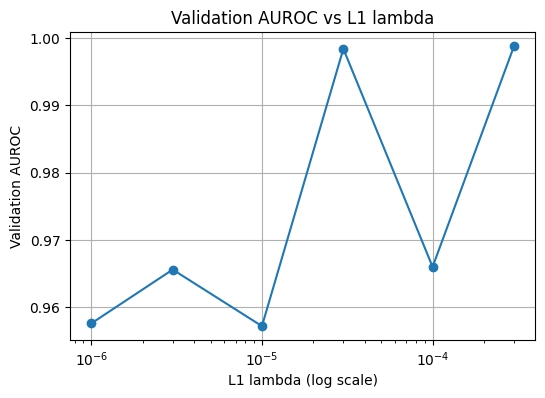

,lambda,fc1_weight_sparsity,fc2_weight_sparsity,fc3_weight_sparsity
0,0.000001,0.0,0.000000,0.0
1,0.000003,0.0,0.000000,0.0
2,0.000010,0.0,0.000000,0.0
3,0.000030,0.0,0.041667,0.0
4,0.000100,0.0,0.000000,0.0
5,0.000300,0.0,0.000000,0.0


In [7]:

# Cell: Plot validation AUC vs L1 lambda and show sparsity
plt.figure(figsize=(6,4))
plt.semilogx(l1_df['lambda'], l1_df['val_auc'], marker='o')
plt.xlabel('L1 lambda (log scale)'); plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs L1 lambda')
plt.grid(True)
plt.show()

# Sparsity table
spars_rows = []
for r in l1_results:
    s = r['sparsity']
    spars_rows.append({'lambda': r['lambda'],
                       'fc1_weight_sparsity': s.get('fc1.weight', None),
                       'fc2_weight_sparsity': s.get('fc2.weight', None),
                       'fc3_weight_sparsity': s.get('fc3.weight', None)})
spars_df = pd.DataFrame(spars_rows)
spars_df


In [8]:

# Cell: L2 (weight decay) tuning via validation
l2_grid = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
l2_results = []
for wd in l2_grid:
    print('Training with weight_decay =', wd)
    model = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
    m_trained, hist = train_model(model, X_train_main, y_train_main, X_val, y_val,
                                  epochs=2000, batch_size=64, lr=1e-3, weight_decay=wd, patience=50, verbose=False)
    # Compute validation AUC
    m_trained.eval()
    with torch.no_grad():
        val_logits = m_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
    val_auc = roc_auc_score(y_val, val_probs)
    l2_results.append({'weight_decay':wd, 'val_auc':val_auc, 'params':count_parameters(m_trained)})
    print(f' wd={wd} val_auc={val_auc:.4f}')
l2_df = pd.DataFrame(l2_results)
l2_df


Training with weight_decay = 0.0
 wd=0.0 val_auc=0.9584
Training with weight_decay = 1e-06
 wd=1e-06 val_auc=0.9988
Training with weight_decay = 1e-05
 wd=1e-05 val_auc=0.9992
Training with weight_decay = 0.0001
 wd=0.0001 val_auc=0.9580
Training with weight_decay = 0.001
 wd=0.001 val_auc=0.9984
Training with weight_decay = 0.01
 wd=0.01 val_auc=0.9680


,weight_decay,val_auc,params
0,0.000000,0.9584,49
1,0.000001,0.9988,49
2,0.000010,0.9992,49
3,0.000100,0.9580,49
4,0.001000,0.9984,49
5,0.010000,0.9680,49


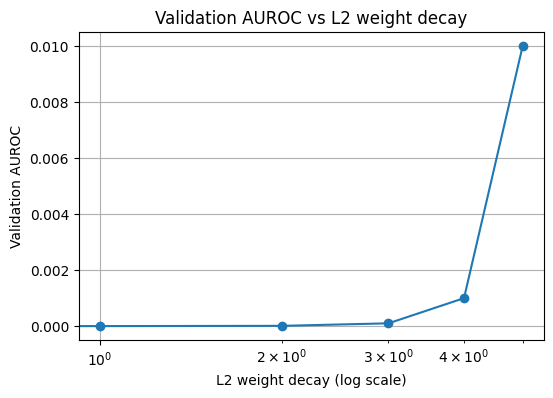

,weight_decay
0,0.000000
1,0.000001
2,0.000010
3,0.000100
4,0.001000
5,0.010000


In [9]:
# Cell: Plot validation AUC vs L2 lambda and show sparsity
plt.figure(figsize=(6,4))
plt.semilogx(l2_df['weight_decay'] + 1e-10, marker='o')
plt.xlabel('L2 weight decay (log scale)'); plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs L2 weight decay')
plt.grid(True)
plt.show()
# Sparsity table for L2 (though L2 does not induce sparsity)
l2_df
spars_rows = []
for r in l2_results:
    spars_rows.append({'weight_decay': r['weight_decay']})
spars_df = pd.DataFrame(spars_rows)
spars_df

In [10]:
# Cell: Logistic Regression with polynomial features (degree 2 and 3) - Manual implementation
poly_results = []

def create_polynomial_features(X, degree):
    """Manually creates polynomial features up to the specified degree."""
    X_poly = X
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, (X[:, 0]**d).reshape(-1, 1), (X[:, 1]**d).reshape(-1, 1)))
        # Add interaction term for degree 2 and higher
        if d >= 2:
             X_poly = np.hstack((X_poly, (X[:, 0] * X[:, 1]).reshape(-1, 1)))
    return X_poly

for deg in [2, 3]:
    # Manually create polynomial features
    X_train_poly = create_polynomial_features(X_train_main, deg)
    X_val_poly = create_polynomial_features(X_val, deg)

    clf = LogisticRegression(max_iter=5000, random_state=SEED)
    clf.fit(X_train_poly, y_train_main)
    val_probs = clf.predict_proba(X_val_poly)[:,1]
    val_auc = roc_auc_score(y_val, val_probs)
    poly_results.append({'degree':deg, 'val_auc':val_auc, 'coef_count': clf.coef_.size + clf.intercept_.size})
    print(f'Degree {deg} val_auc={val_auc:.4f} coef_count={clf.coef_.size}')
poly_df = pd.DataFrame(poly_results)
poly_df

Degree 2 val_auc=0.9560 coef_count=5
Degree 3 val_auc=0.9964 coef_count=8


,degree,val_auc,coef_count
0,2,0.9560,6
1,3,0.9964,9


In [11]:
# Cell: Evaluate the trained best models on test sets (noise 0.1, 0.2, 0.3)
# For L1 and L2 pick best trained model from earlier results (best val_auc)

# Find best L1 model (highest val_auc)
best_l1 = max(l1_results, key=lambda r: r['val_auc'])
# Re-train best L1 model to ensure we have model object (with same lambda) -- small redundancy
best_l1_lambda = best_l1['lambda']
model_l1 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_l1_trained, _ = train_model(model_l1, X_train_main, y_train_main, X_val, y_val,
                                  epochs=800, batch_size=64, lr=1e-3, l1_lambda=best_l1_lambda, patience=50, verbose=False)

# Best L2 by val_auc
best_l2_entry = max(l2_results, key=lambda r: r['val_auc'])
best_l2_wd = best_l2_entry['weight_decay']
model_l2 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_l2_trained, _ = train_model(model_l2, X_train_main, y_train_main, X_val, y_val,
                                  epochs=800, batch_size=64, lr=1e-3, weight_decay=best_l2_wd, patience=50, verbose=False)

# Base MLP already trained as model_base_trained
# Logistic regression: choose degree 2 model (you can evaluate both)
# Manually create polynomial features for degree 2
X_train_poly2 = create_polynomial_features(X_train_main, 2)
X_test_poly2_10 = create_polynomial_features(X_test_10_s, 2)
X_test_poly2_20 = create_polynomial_features(X_test_20_s, 2)
X_test_poly2_30 = create_polynomial_features(X_test_30_s, 2)

clf_poly2 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_poly2.fit(X_train_poly2, y_train_main)

# Manually create polynomial features for degree 3
X_train_poly3 = create_polynomial_features(X_train_main, 3)
X_test_poly3_10 = create_polynomial_features(X_test_10_s, 3)
X_test_poly3_20 = create_polynomial_features(X_test_20_s, 3)
X_test_poly3_30 = create_polynomial_features(X_test_30_s, 3)

clf_poly3 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_poly3.fit(X_train_poly3, y_train_main)


# Helper to evaluate
def eval_model_torch(model, X):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32).to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
    return preds, probs

def eval_lr(clf, X_poly):
    probs = clf.predict_proba(X_poly)[:,1]
    preds = (probs >= 0.5).astype(int)
    return preds, probs

# Evaluate on the three test sets
models_info = []
# Base MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_base_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    print(f"Noise: {noise_label}, TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(f"Calculated Accuracy: {acc}")
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_base', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_base_trained)})
# L1 MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_l1_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_L1', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_l1_trained)})
# L2 MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_l2_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_L2', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_l2_trained)})
# Logistic degree2
for (Xtest_poly, ytest, noise_label) in [(X_test_poly2_10, y_test_10, 0.1), (X_test_poly2_20, y_test_20, 0.2), (X_test_poly2_30, y_test_30, 0.3)]:
    p, prob = eval_lr(clf_poly2, Xtest_poly)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'LogReg_deg2', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':clf_poly2.coef_.size + clf_poly2.intercept_.size})
# Logistic degree3
for (Xtest_poly, ytest, noise_label) in [(X_test_poly3_10, y_test_10, 0.1), (X_test_poly3_20, y_test_20, 0.2), (X_test_poly3_30, y_test_30, 0.3)]:
    p, prob = eval_lr(clf_poly3, Xtest_poly)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'LogReg_deg3', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':clf_poly3.coef_.size + clf_poly3.intercept_.size})

results_df = pd.DataFrame(models_info)
results_pivot_acc = results_df.pivot(index='model', columns='noise', values='acc')
results_pivot_auc = results_df.pivot(index='model', columns='noise', values='auc')

Noise: 0.1, TP: 250, TN: 249, FP: 1, FN: 0
Calculated Accuracy: 0.998
Noise: 0.2, TP: 242, TN: 245, FP: 5, FN: 8
Calculated Accuracy: 0.974
Noise: 0.3, TP: 227, TN: 227, FP: 23, FN: 23
Calculated Accuracy: 0.908


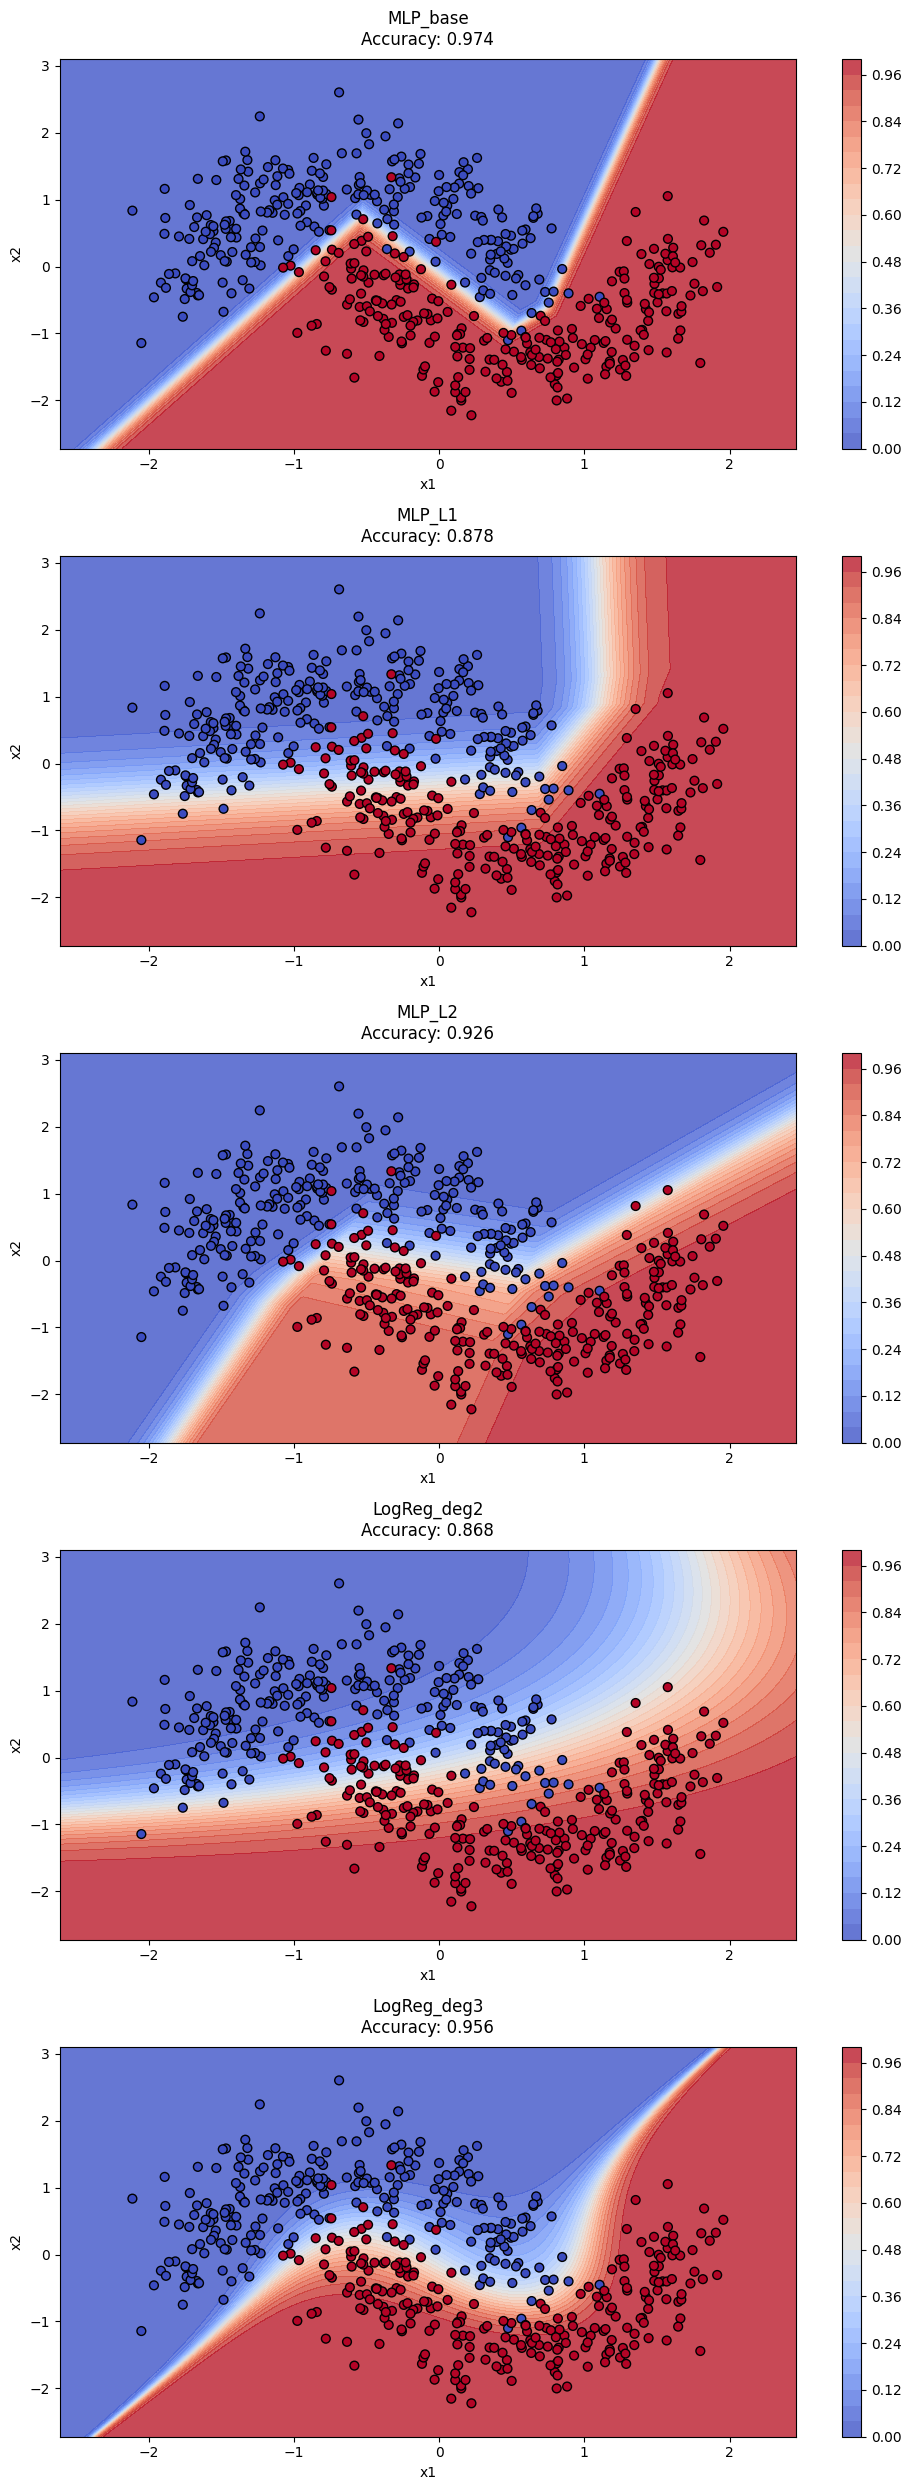

In [12]:
# Cell: Decision boundaries for the four main models (noise 0.2). We'll plot MLP_base, MLP_L1, MLP_L2, LogReg_deg2
xx_min, xx_max = X_test_20_s[:,0].min() - .5, X_test_20_s[:,0].max() + .5
yy_min, yy_max = X_test_20_s[:,1].min() - .5, X_test_20_s[:,1].max() + .5
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Create polynomial features for the grid for Logistic Regression models
grid_poly2 = create_polynomial_features(grid, 2)
grid_poly3 = create_polynomial_features(grid, 3)


# Get accuracies for noise=0.2
acc_base = results_df[results_df['model'] == 'MLP_base'][results_df['noise'] == 0.2]['acc'].iloc[0]
acc_l1 = results_df[results_df['model'] == 'MLP_L1'][results_df['noise'] == 0.2]['acc'].iloc[0]
acc_l2 = results_df[results_df['model'] == 'MLP_L2'][results_df['noise'] == 0.2]['acc'].iloc[0]
acc_logreg2 = results_df[results_df['model'] == 'LogReg_deg2'][results_df['noise'] == 0.2]['acc'].iloc[0]
acc_logreg3 = results_df[results_df['model'] == 'LogReg_deg3'][results_df['noise'] == 0.2]['acc'].iloc[0]

# Create figure with 5 rows and 1 column
fig, axes = plt.subplots(5, 1, figsize=(10, 25))
models_for_plot = [
    ('MLP_base', model_base_trained, None, acc_base),
    ('MLP_L1', model_l1_trained, None, acc_l1),
    ('MLP_L2', model_l2_trained, None, acc_l2),
    ('LogReg_deg2', clf_poly2, grid_poly2, acc_logreg2),
    ('LogReg_deg3', clf_poly3, grid_poly3, acc_logreg3)
]

for ax, (name, mdl, poly_grid, acc) in zip(axes, models_for_plot):
    if 'LogReg' in name:
        probs = mdl.predict_proba(poly_grid)[:,1].reshape(xx.shape)
    else:
        mdl.eval()
        with torch.no_grad():
            logits = mdl(torch.tensor(grid, dtype=torch.float32).to(device))
            probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    # Create contour plot
    contour = ax.contourf(xx, yy, probs, levels=25, cmap='coolwarm', alpha=0.8) # Changed colormap to coolwarm

    # Add scatter plot of test points
    ax.scatter(X_test_20_s[:,0], X_test_20_s[:,1], c=y_test_20, cmap='coolwarm', edgecolor='k', s=40) # Changed colormap to coolwarm

    # Add title with accuracy
    ax.set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=12, pad=10)

    # Add axes labels
    ax.set_xlabel('x1', fontsize=10)
    ax.set_ylabel('x2', fontsize=10)

    # Add colorbar
    plt.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()

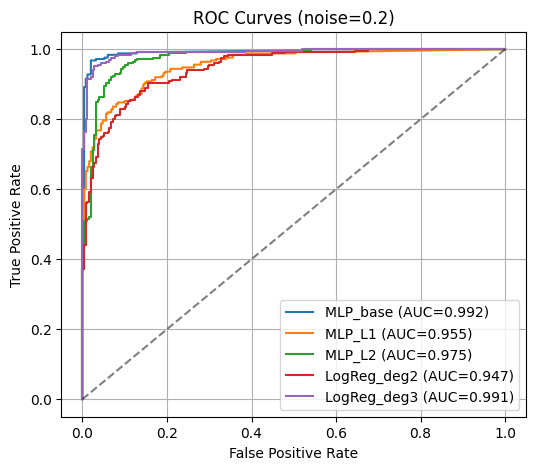

In [13]:
# Cell: ROC curves (noise 0.2) for main models
plt.figure(figsize=(6,5))
from sklearn.metrics import roc_curve
def plot_roc_for_model(name, predict_func):
    probs = predict_func(X_test_20_s)
    fpr, tpr, _ = roc_curve(y_test_20, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')

# Helper to evaluate Logistic Regression with polynomial features for ROC curve
def eval_lr_poly(clf, X, degree):
    X_poly = create_polynomial_features(X, degree)
    probs = clf.predict_proba(X_poly)[:, 1]
    return probs

plot_roc_for_model('MLP_base', lambda X: eval_model_torch(model_base_trained, X)[1])
plot_roc_for_model('MLP_L1', lambda X: eval_model_torch(model_l1_trained, X)[1])
plot_roc_for_model('MLP_L2', lambda X: eval_model_torch(model_l2_trained, X)[1])
plot_roc_for_model('LogReg_deg2', lambda X: eval_lr_poly(clf_poly2, X, 2))
plot_roc_for_model('LogReg_deg3', lambda X: eval_lr_poly(clf_poly3, X, 3))

plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves (noise=0.2)')
plt.legend(); plt.grid(True)
plt.show()

In [14]:
# Cell: Class imbalance in training set (70:30). We'll create a new imbalanced training set sized N_TRAIN with same distribution.
def make_imbalanced_train(X_raw, y_raw, target_ratio=0.7, random_state=SEED):
    # target_ratio = fraction of class 0
    rng = np.random.RandomState(random_state)
    # separate classes
    X0 = X_raw[y_raw==0]
    X1 = X_raw[y_raw==1]
    n = len(y_raw)
    n0 = int(n * target_ratio)
    n1 = n - n0
    # sample with replacement if not enough samples (we have enough though)
    idx0 = rng.choice(len(X0), size=n0, replace=True)
    idx1 = rng.choice(len(X1), size=n1, replace=True)
    X_new = np.vstack([X0[idx0], X1[idx1]])
    y_new = np.hstack([np.zeros(n0,dtype=int), np.ones(n1,dtype=int)])
    # shuffle
    perm = rng.permutation(n)
    return X_new[perm], y_new[perm]

X_train_imb_raw, y_train_imb_raw = make_imbalanced_train(X_train_raw, y_train_raw, target_ratio=0.7, random_state=SEED)
# Standardize using original train scaler (fit on original balanced train)
X_train_imb = scaler.transform(X_train_imb_raw)
# Validation split from imbalanced train
X_train_imb_main, X_val_imb, y_train_imb_main, y_val_imb = train_test_split(X_train_imb, y_train_imb_raw, test_size=0.2, stratify=y_train_imb_raw, random_state=SEED)

print('Imbalanced train class distribution (train main):', np.bincount(y_train_imb_main), 'val:', np.bincount(y_val_imb))

imbalanced_results = []
imbalanced_weighted_results = []

# Train a baseline MLP on imbalanced train .
print("Training MLP (Base) on imbalanced data ....")
model_imb_base = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_base_trained, _ = train_model(model_imb_base, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb, epochs=2000, patience=50, verbose=False)
p_imb_base, prob_imb_base = eval_model_torch(model_imb_base_trained, X_test_20_s)
acc_imb_base = accuracy_score(y_test_20, p_imb_base)
auc_imb_base = roc_auc_score(y_test_20, prob_imb_base)
imbalanced_results.append({'model': 'MLP (Base)', 'accuracy': acc_imb_base, 'auc': auc_imb_base})
print(f'MLP (Base) on balanced test .: ACC = {acc_imb_base:.3f}, AUC = {auc_imb_base:.3f}')


# Train MLP (L1) on imbalanced train .
print("\nTraining MLP (L1) on imbalanced data ....")
best_l1_lambda = max(l1_results, key=lambda r: r['val_auc'])['lambda']
model_imb_l1 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_l1_trained, _ = train_model(model_imb_l1, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb,
                                      epochs=2000, batch_size=64, lr=1e-3, l1_lambda=best_l1_lambda, patience=50, verbose=False)
p_imb_l1, prob_imb_l1 = eval_model_torch(model_imb_l1_trained, X_test_20_s)
acc_imb_l1 = accuracy_score(y_test_20, p_imb_l1)
auc_imb_l1 = roc_auc_score(y_test_20, prob_imb_l1)
imbalanced_results.append({'model': 'MLP (L1)', 'accuracy': acc_imb_l1, 'auc': auc_imb_l1})
print(f'MLP (L1) on balanced test .: ACC = {acc_imb_l1:.3f}, AUC = {auc_imb_l1:.3f}')


# Train MLP (L2) on imbalanced train .
print("\nTraining MLP (L2) on imbalanced data ....")
best_l2_wd = max(l2_results, key=lambda r: r['val_auc'])['weight_decay']
model_imb_l2 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_l2_trained, _ = train_model(model_imb_l2, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb,
                                      epochs=2000, batch_size=64, lr=1e-3, weight_decay=best_l2_wd, patience=50, verbose=False)
p_imb_l2, prob_imb_l2 = eval_model_torch(model_imb_l2_trained, X_test_20_s)
acc_imb_l2 = accuracy_score(y_test_20, p_imb_l2)
auc_imb_l2 = roc_auc_score(y_test_20, prob_imb_l2)
imbalanced_results.append({'model': 'MLP (L2)', 'accuracy': acc_imb_l2, 'auc': auc_imb_l2})
print(f'MLP (L2) on balanced test .: ACC = {acc_imb_l2:.3f}, AUC = {auc_imb_l2:.3f}')


# Train Logistic Regression (Degree 2) on imbalanced train .
print("\nTraining LogReg (deg=2) on imbalanced data ....")
X_train_imb_poly2 = create_polynomial_features(X_train_imb_main, 2)
X_test_20_s_poly2 = create_polynomial_features(X_test_20_s, 2) # Need poly features for balanced test set
clf_imb_poly2 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_imb_poly2.fit(X_train_imb_poly2, y_train_imb_main)
p_imb_poly2, prob_imb_poly2 = eval_lr(clf_imb_poly2, X_test_20_s_poly2)
acc_imb_poly2 = accuracy_score(y_test_20, p_imb_poly2)
auc_imb_poly2 = roc_auc_score(y_test_20, prob_imb_poly2)
imbalanced_results.append({'model': 'LogReg (deg=2)', 'accuracy': acc_imb_poly2, 'auc': auc_imb_poly2})
print(f'LogReg (deg=2) on balanced test .: ACC = {acc_imb_poly2:.3f}, AUC = {auc_imb_poly2:.3f}')


# Train Logistic Regression (Degree 3) on imbalanced train .
print("\nTraining LogReg (deg=3) on imbalanced data h...")
X_train_imb_poly3 = create_polynomial_features(X_train_imb_main, 3)
X_test_20_s_poly3 = create_polynomial_features(X_test_20_s, 3) # Need poly features for balanced test set
clf_imb_poly3 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_imb_poly3.fit(X_train_imb_poly3, y_train_imb_main)
p_imb_poly3, prob_imb_poly3 = eval_lr(clf_imb_poly3, X_test_20_s_poly3)
acc_imb_poly3 = accuracy_score(y_test_20, p_imb_poly3)
auc_imb_poly3 = roc_auc_score(y_test_20, prob_imb_poly3)
imbalanced_results.append({'model': 'LogReg (deg=3)', 'accuracy': acc_imb_poly3, 'auc': auc_imb_poly3})
print(f'LogReg (deg=3) on balanced test .: ACC = {acc_imb_poly3:.3f}, AUC = {auc_imb_poly3:.3f}')



# Display results
imbalanced_results_df = pd.DataFrame(imbalanced_results)
print("\nResults on Balanced Test Set (trained on Imbalanced Data - No Weights):")
display(imbalanced_results_df)


Imbalanced train class distribution (train main): [280 120] val: [70 30]
Training MLP (Base) on imbalanced data ....
MLP (Base) on balanced test .: ACC = 0.958, AUC = 0.994

Training MLP (L1) on imbalanced data ....
MLP (L1) on balanced test .: ACC = 0.968, AUC = 0.994

Training MLP (L2) on imbalanced data ....
MLP (L2) on balanced test .: ACC = 0.852, AUC = 0.948

Training LogReg (deg=2) on imbalanced data ....
LogReg (deg=2) on balanced test .: ACC = 0.850, AUC = 0.948

Training LogReg (deg=3) on imbalanced data h...
LogReg (deg=3) on balanced test .: ACC = 0.962, AUC = 0.991

Results on Balanced Test Set (trained on Imbalanced Data - No Weights):


,model,accuracy,auc
0,MLP (Base),0.958,0.993552
1,MLP (L1),0.968,0.994304
2,MLP (L2),0.852,0.947696
3,LogReg (deg=2),0.850,0.948048
4,LogReg (deg=3),0.962,0.990720


In [15]:
# Create comprehensive results table
# 1. Get the best L1 and L2 parameters
best_l1_lambda = best_l1['lambda']
best_l2_wd = best_l2_entry['weight_decay']

# 2. Create a summary DataFrame
summary_data = []

# Base MLP
base_info = {
    'Model': 'MLP (Base)',
    'Parameters': count_parameters(model_base_trained),
    'Architecture': '2-4-6-1',
    'Regularization': 'Early stopping only',
    'Test Acc (0.1)': results_df[results_df['model'] == 'MLP_base'][results_df['noise'] == 0.1]['acc'].iloc[0],
    'Test Acc (0.2)': results_df[results_df['model'] == 'MLP_base'][results_df['noise'] == 0.2]['acc'].iloc[0],
    'Test Acc (0.3)': results_df[results_df['model'] == 'MLP_base'][results_df['noise'] == 0.3]['acc'].iloc[0],
    'Test AUC (0.2)': results_df[results_df['model'] == 'MLP_base'][results_df['noise'] == 0.2]['auc'].iloc[0],
}
summary_data.append(base_info)

# L1 MLP
l1_sparsity = get_layerwise_sparsity(model_l1_trained)
l1_info = {
    'Model': 'MLP (L1)',
    'Parameters': count_parameters(model_l1_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L1 (λ={best_l1_lambda:.1e})',
    'Test Acc (0.1)': results_df[results_df['model'] == 'MLP_L1'][results_df['noise'] == 0.1]['acc'].iloc[0],
    'Test Acc (0.2)': results_df[results_df['model'] == 'MLP_L1'][results_df['noise'] == 0.2]['acc'].iloc[0],
    'Test Acc (0.3)': results_df[results_df['model'] == 'MLP_L1'][results_df['noise'] == 0.3]['acc'].iloc[0],
    'Test AUC (0.2)': results_df[results_df['model'] == 'MLP_L1'][results_df['noise'] == 0.2]['auc'].iloc[0],
}
summary_data.append(l1_info)

# L2 MLP
l2_info = {
    'Model': 'MLP (L2)',
    'Parameters': count_parameters(model_l2_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L2 (λ={best_l2_wd:.1e})',
    'Test Acc (0.1)': results_df[results_df['model'] == 'MLP_L2'][results_df['noise'] == 0.1]['acc'].iloc[0],
    'Test Acc (0.2)': results_df[results_df['model'] == 'MLP_L2'][results_df['noise'] == 0.2]['acc'].iloc[0],
    'Test Acc (0.3)': results_df[results_df['model'] == 'MLP_L2'][results_df['noise'] == 0.3]['acc'].iloc[0],
    'Test AUC (0.2)': results_df[results_df['model'] == 'MLP_L2'][results_df['noise'] == 0.2]['auc'].iloc[0],
}
summary_data.append(l2_info)

# LogReg degree 2
logreg2_info = {
    'Model': 'LogReg (deg=2)',
    'Parameters': clf_poly2.coef_.size + clf_poly2.intercept_.size,
    'Architecture': 'Polynomial deg=2',
    'Regularization': 'None',
    'Test Acc (0.1)': results_df[results_df['model'] == 'LogReg_deg2'][results_df['noise'] == 0.1]['acc'].iloc[0],
    'Test Acc (0.2)': results_df[results_df['model'] == 'LogReg_deg2'][results_df['noise'] == 0.2]['acc'].iloc[0],
    'Test Acc (0.3)': results_df[results_df['model'] == 'LogReg_deg2'][results_df['noise'] == 0.3]['acc'].iloc[0],
    'Test AUC (0.2)': results_df[results_df['model'] == 'LogReg_deg2'][results_df['noise'] == 0.2]['auc'].iloc[0],
}
summary_data.append(logreg2_info)

# LogReg degree 3
logreg3_info = {
    'Model': 'LogReg (deg=3)',
    'Parameters': clf_poly3.coef_.size + clf_poly3.intercept_.size,
    'Architecture': 'Polynomial deg=3',
    'Regularization': 'None',
    'Test Acc (0.1)': results_df[results_df['model'] == 'LogReg_deg3'][results_df['noise'] == 0.1]['acc'].iloc[0],
    'Test Acc (0.2)': results_df[results_df['model'] == 'LogReg_deg3'][results_df['noise'] == 0.2]['acc'].iloc[0],
    'Test Acc (0.3)': results_df[results_df['model'] == 'LogReg_deg3'][results_df['noise'] == 0.3]['acc'].iloc[0],
    'Test AUC (0.2)': results_df[results_df['model'] == 'LogReg_deg3'][results_df['noise'] == 0.2]['auc'].iloc[0],
}
summary_data.append(logreg3_info)

# Add imbalanced data results .
imbalanced_info_base = {
    'Model': 'MLP (Base - Imbalanced Train)',
    'Parameters': count_parameters(model_imb_base_trained),
    'Architecture': '2-4-6-1',
    'Regularization': 'Early stopping only',
    'Test Acc (0.1)': None,  # Only tested on noise=0.2
    'Test Acc (0.2)': acc_imb_base,
    'Test Acc (0.3)': None,
    'Test AUC (0.2)': auc_imb_base,
}
summary_data.append(imbalanced_info_base)

imbalanced_info_l1 = {
    'Model': 'MLP (L1 - Imbalanced Train )',
    'Parameters': count_parameters(model_imb_l1_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L1 (λ={best_l1_lambda:.1e})',
    'Test Acc (0.1)': None,  # Only tested on noise=0.2
    'Test Acc (0.2)': acc_imb_l1,
    'Test Acc (0.3)': None,
    'Test AUC (0.2)': auc_imb_l1,
}
summary_data.append(imbalanced_info_l1)

imbalanced_info_l2 = {
    'Model': 'MLP (L2 - Imbalanced Train)',
    'Parameters': count_parameters(model_imb_l2_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L2 (λ={best_l2_wd:.1e})',
    'Test Acc (0.1)': None,  # Only tested on noise=0.2
    'Test Acc (0.2)': acc_imb_l2,
    'Test Acc (0.3)': None,
    'Test AUC (0.2)': auc_imb_l2,
}
summary_data.append(imbalanced_info_l2)

imbalanced_info_logreg2 = {
    'Model': 'LogReg (deg=2 - Imbalanced Train)',
    'Parameters': clf_imb_poly2.coef_.size + clf_imb_poly2.intercept_.size,
    'Architecture': 'Polynomial deg=2',
    'Regularization': 'None',
    'Test Acc (0.1)': None,  # Only tested on noise=0.2
    'Test Acc (0.2)': acc_imb_poly2,
    'Test Acc (0.3)': None,
    'Test AUC (0.2)': auc_imb_poly2,
}
summary_data.append(imbalanced_info_logreg2)

imbalanced_info_logreg3 = {
    'Model': 'LogReg (deg=3 - Imbalanced Train )',
    'Parameters': clf_imb_poly3.coef_.size + clf_imb_poly3.intercept_.size,
    'Architecture': 'Polynomial deg=3',
    'Regularization': 'None',
    'Test Acc (0.1)': None,  # Only tested on noise=0.2
    'Test Acc (0.2)': acc_imb_poly3,
    'Test Acc (0.3)': None,
    'Test AUC (0.2)': auc_imb_poly3,
}
summary_data.append(imbalanced_info_logreg3)





# Create DataFrame and display
summary_df = pd.DataFrame(summary_data)

# Format numeric columns
numeric_cols = ['Test Acc (0.1)', 'Test Acc (0.2)', 'Test Acc (0.3)', 'Test AUC (0.2)']
for col in numeric_cols:
    if col in summary_df.columns:
      summary_df[col] = summary_df[col].apply(lambda x: '{:.3f}'.format(x) if pd.notna(x) else '-')


# Display the table
print("\nComprehensive Results Summary:")
print("-------------------------------")
display(summary_df.fillna('-'))


Comprehensive Results Summary:
-------------------------------


,Model,Parameters,Architecture,Regularization,Test Acc (0.1),Test Acc (0.2),Test Acc (0.3),Test AUC (0.2)
0,MLP (Base),49,2-4-6-1,Early stopping only,0.998,0.974,0.908,0.992
1,MLP (L1),49,2-4-6-1,L1 (λ=3.0e-04),0.914,0.878,0.860,0.955
2,MLP (L2),49,2-4-6-1,L2 (λ=1.0e-05),0.964,0.926,0.904,0.975
3,LogReg (deg=2),6,Polynomial deg=2,None,0.892,0.868,0.852,0.947
4,LogReg (deg=3),9,Polynomial deg=3,None,0.990,0.956,0.908,0.991
5,MLP (Base - Imbalanced Train),49,2-4-6-1,Early stopping only,-,0.958,-,0.994
6,MLP (L1 - Imbalanced Train ),49,2-4-6-1,L1 (λ=3.0e-04),-,0.968,-,0.994
7,MLP (L2 - Imbalanced Train),49,2-4-6-1,L2 (λ=1.0e-05),-,0.852,-,0.948
8,LogReg (deg=2 - Imbalanced Train),6,Polynomial deg=2,None,-,0.850,-,0.948
9,LogReg (deg=3 - Imbalanced Train ),9,Polynomial deg=3,None,-,0.962,-,0.991


In [16]:
# Cell: Calculate class weights for imbalanced training data
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for the imbalanced training data
classes = np.unique(y_train_imb_main)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_imb_main)
class_weights_dict = dict(zip(classes, class_weights))

print("Class weights for imbalanced training data:", class_weights_dict)

Class weights for imbalanced training data: {np.int64(0): np.float64(0.7142857142857143), np.int64(1): np.float64(1.6666666666666667)}



## Discussion & Analysis

**Effect of L1 on sparsity and boundary jaggedness**  
- L1 encourages weights to become exactly zero, producing sparser models (see layer-wise sparsity table). Higher L1 λ increases sparsity. Sparse networks can lead to more piecewise decisions and can make decision boundaries more **jagged** (less smooth) because fewer active parameters create coarser decision surfaces.

**Effect of L2 on smoothness and margin**  
- L2 (weight decay) penalizes large weights but does not push them exactly to zero. It tends to distribute weight reductions across parameters and produces smoother decision boundaries and larger margins. L2 often improves generalization by discouraging extreme parameter values and thereby smoothing the classifier's decision surface.

**Effect of class imbalance (70:30) in trainset**  
- Training with an imbalanced training set while testing on a balanced test may increase overall accuracy if the model learns the majority class well, but **AUROC** is a better indicator of ranking performance and is less sensitive to class imbalance. If accuracy increases while AUC drops, that typically indicates the model is biased toward the majority class.
- Remedies include class-weighted loss, resampling (oversample minority, undersample majority), and threshold tuning.


